# 1 概述

再来回忆一下我们的终极目标，我们的终极目标是搭建一个人脸识别的模型，经过之前的努力，我们已经训练出来了一个人脸检测模型，然后我们就可以利用检测到的人脸，将其输入人脸识别模型中，来达到人脸识别的目的。

现在有一个问题，之前的人脸检测模型是通过darknet平台实现的，但是接下来的人脸识别模型我们不会使用darknet网络了，而会使用keras+tensorflow，为了整个模型的灵活性，也为了更好的管理人脸识别模型，我们需要将darknet移植出来，用Python来实现。当然并不会抑制整个darknet平台，仅仅移植和YOLO相关的部分，当然，我也不会自己动手去移植，因为已经有人已经帮助我们做好了这些事情！

所以接下来，我们将使用[YAD2K](https://github.com/allanzelener/YAD2K)这个开源工程，其实就是darknet的Python版本，但是支持的模型仅仅是类YOLO的模型（tiny-yolo等）。

所以darknet在本项目中就是为了训练YOLO人脸检测模型的权重，然后我们利用YAD2K来搭建YOLO人脸检测模型，加载权重。最后再搭建人脸识别模型。

# 2 YAD2K

本项目就是基于[YAD2K](https://github.com/allanzelener/YAD2K)上进行开发的，所以你没必要再去克隆。再声明一点，本notebook就位于YAD2K内。

接下来我们就来走一遍YAD2K的流程，看看他到底做了哪些事情。然后我们再提取我们需要的部分来搭建YOLO模型！

## 2.1 YAD2K运行环境搭建

首先根据YAD2K的使用说明来搭建环境，输入如下命令

    git clone https://github.com/allanzelener/yad2k.git
    cd yad2k
    
    ## 为了方便，作者把yad2k的环境信息都放在了environment.yml文件里面，运行下面的命令创建环境
    conda env create -f environment.yml
    source activate yad2k
    
    # 安装一些常用的库
    pip install numpy h5py pillow
    # 安装GPU版本的tensorflow，如果没有GPU的话，安装CPU版本的也可以，就是CPU版本的预测的速度要慢很多
    pip install tensorflow-gpu  # CPU-only: conda install -c conda-forge tensorflow
    pip install keras # Possibly older release: conda install keras

## 2.2 YOLO模型配置文件以及权重

就像之前[第二个notebook](https://github.com/rikichou/yolo/blob/master/YOLO_face_detection_and_recognition_2--train_yolo_on_CelebA_datasheet.ipynb)说的那样，darknet需要一个模型的配置文件和权重才能把模型搭建起来，同理，对于YAD2K也需要这两样东西。

    1，YOLO模型配置文件，本git已经自带，位于cfg/yolov2-celeba.cfg
    2，权重文件是我们在CelebA数据集上训练的权重，有大概200M，我放在了另一个仓库里面，记得克隆前要安装git LFS
        git lfs clone https://github.com/rikizhou/yolo_face_weights.git
      下载完了把它拷贝到weights目录下就可以了

## 2.3 转换darknet模型

在上一步中，我们获得darknet下载YOLO模型的配置文件和权重，这两样东西包含了搭建模型需要的全部东西。现在我们就根据这两样东西，将darknet模型转换为keras模型。

注意注意！各位同学！！！这里需要更改源码的一个BUG，在yad2k.py，在第 83 行，将 buffer=weights_file.read(16) 改为 buffer=weights_file.read(20)，否则会出现权重错位，导致模型完全错误！当然，在本项目中，已经更改好了！

./yad2k.py cfg/yolov2-celeba.cfg weights/yolov2-celeba_5000.weights model_data/yolo_face_detectoin.h5

运行了之后，会在model_data目录下生成yolo_face_detectoin_anchors.txt文件

## 2.4 预测测试图片

YAD2K是利用test_yolo.py这个文件来实现预测的，所以我们应该查看其源代码，分析该脚本需要提供什么参数？
    
    model_path：keras模型的路径，model_data/yolo_face_detectoin.h5
    --anchors_path：我们需要指定anchors文件的路径，model_data/yolo_face_detectoin_anchors.txt
    --classes_path：类别文件的路径，里面指定了每个类别的名字，我们就只有一个face，model_data/celeba_classes.txt
    --test_path：输入的测试图片的路径，默认是在images目录下，我们就用默认的就好了
    --output_path：输出的测试图片的路径，默认在images/out，我们就用默认
    --score_threshold：将每个anchors的pc乘以该anchors的类别概率就等于scores，对于YOLO模型的预测输出，如果某个anchors的score小于score_threshold，那么该anchors的预测将直接会被删除，不会参与IOU的流程。默认为0.3，我们暂时使用0.3，然后根据效果来调节该阈值。
    --iou_threshold：IOU的阈值，在执行非最大值抑制（NMS）的时候，如果两个同类预测的bbox的IOU>iou_threshold，那么就认为该对象被重复检测了，需要删除几率小的那个Bbox。默认为0.5，我们暂时使用0.5，然后根据效果来调节该阈值。
    
如果我上面说的这些大家不懂的话，那么可能需要看关于YOLO的视频了，这里推荐吴恩达教授Coursera上的DeepLearning.ai系列课程，在CNN部分讲解了YOLO的详细流程。

接下来我们就要预测一下images里面的图片，输出的结果在images/out文件夹里面

./test_yolo.py model_data/yolo_face_detectoin.h5 -a model_data/yolo_face_detectoin_anchors.txt -c model_data/celeba_classes.txt

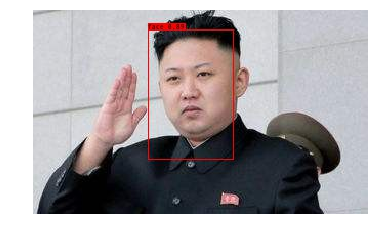

In [4]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
%matplotlib inline
img_path = "images/out/timg.jpeg"

plt.figure(figsize=(6,6))

img = cv2.imread(img_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis("off")
plt.show()

# 3 我们需要怎样的模型